<a href="https://colab.research.google.com/github/MultimodalUniverse/MultimodalUniverse/blob/main/notebooks/getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Multimodal Universe Collaboration

Licensed under MIT License (the "License")

**Authors**:
- [@EiffL](https://github.com/EiffL) (Francois Lanusse)

# Getting Started with the Multimodal Universe Dataset!

<p align="center">
<img src="https://raw.githubusercontent.com/MultimodalUniverse/MultimodalUniverse/main/assets/astropile.png" alt="drawing" width="400"/>
<p>

### Overview

In this notebook we demonstrate how to access the data from the Multimodal Universe dataset, provide explanations about how to understand and work with each modality, and provide examples of multimodal cross-matching.

### Learning Objectives

In this notebook, we will learn how to:
 - Access datasets of different modalities
 - Cross-match different datasets


### Installs and Imports

To get started with the dataset, we only need to install Hugging Face Datasets:

In [ ]:
# Installing Hugging Face datasets
!pip install datasets --quiet

And that's it, we are set 😀 Let's just import a few things and then we can get started:

In [3]:
%pylab inline
from datasets import load_dataset

Populating the interactive namespace from numpy and matplotlib


## Image Samples


In [4]:
dset_ls = load_dataset("MultimodalUniverse/legacysurvey",
                       streaming=True,
                       split='train')
dset_ls = dset_ls.with_format("numpy")
dset_iterator = iter(dset_ls)

In [5]:
example = next(dset_iterator)

In [6]:
# Let's inspect what is contained in an example
example.keys()

dict_keys(['image', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_I', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'object_id'])

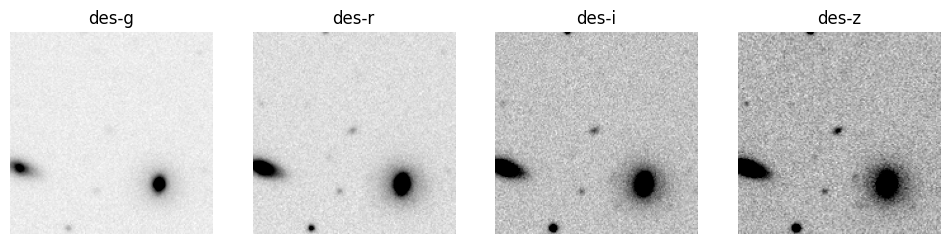

In [7]:
figure(figsize=(12,4))
for i,b in enumerate(example['image']['band']):
  subplot(1,4,i+1)
  title(f'{b}')
  imshow(example['image']['array'][i],vmax=0.1, cmap='gray_r')
  axis('off')

## Spectra Samples

In [8]:
dset_sdss = load_dataset("MultimodalUniverse/sdss",
                       streaming=True,
                       split='train')
dset_sdss = dset_sdss.with_format("numpy")
dset_iterator = iter(dset_sdss)

In [9]:
example = next(dset_iterator)

In [10]:
# Let's inspect what is contained in an example
example.keys()

dict_keys(['spectrum', 'VDISP', 'VDISP_ERR', 'Z', 'Z_ERR', 'ZWARNING', 'SPECTROFLUX_U', 'SPECTROFLUX_G', 'SPECTROFLUX_R', 'SPECTROFLUX_I', 'SPECTROFLUX_Z', 'SPECTROFLUX_IVAR_U', 'SPECTROFLUX_IVAR_G', 'SPECTROFLUX_IVAR_R', 'SPECTROFLUX_IVAR_I', 'SPECTROFLUX_IVAR_Z', 'SPECTROSYNFLUX_U', 'SPECTROSYNFLUX_G', 'SPECTROSYNFLUX_R', 'SPECTROSYNFLUX_I', 'SPECTROSYNFLUX_Z', 'SPECTROSYNFLUX_IVAR_U', 'SPECTROSYNFLUX_IVAR_G', 'SPECTROSYNFLUX_IVAR_R', 'SPECTROSYNFLUX_IVAR_I', 'SPECTROSYNFLUX_IVAR_Z', 'object_id'])

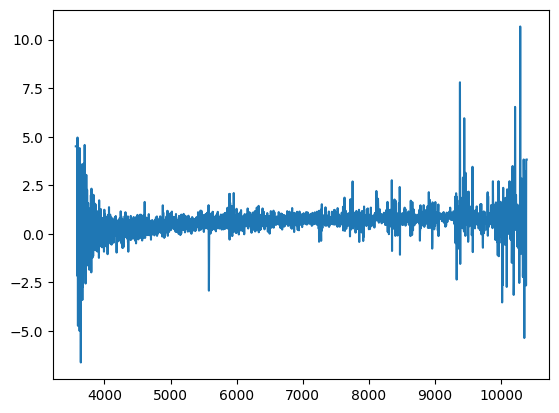

In [16]:
# For plotting, we remove the padding values that are recognizable by the -1
m = example['spectrum']['lambda'] > 0

plot(example['spectrum']['lambda'][m],
     example['spectrum']['flux'][m])

## Time-Series sample

In [18]:
dset_plasticc = load_dataset("MultimodalUniverse/plasticc",
                       streaming=True,
                       split='train')
dset_plasticc = dset_plasticc.with_format("numpy")
dset_iterator = iter(dset_plasticc)

In [19]:
example = next(dset_iterator)

In [20]:
example.keys()

dict_keys(['lightcurve', 'hostgal_photoz', 'hostgal_specz', 'redshift', 'obj_type', 'object_id'])

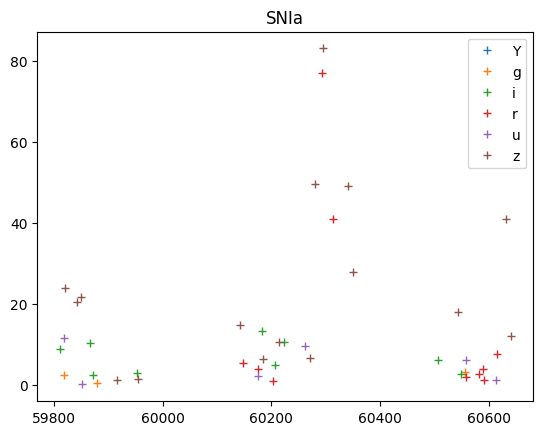

In [34]:
for b in unique(example['lightcurve']['band']):
  m = (example['lightcurve']['flux'] > 0) & (example['lightcurve']['band'] == b)
  plot(example['lightcurve']['time'][m],
      example['lightcurve']['flux'][m],'+', label=b)
  title(example['obj_type'])
legend();